In [4]:
import os
import sys

import nltk
import tweepy
from dotenv import load_dotenv
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from datetime import datetime
import re
import cv2
import numpy as np
import pandas as pd
import pickle
# NOTE: THE WORDCLOUD PACKAGE ISN'T WORKING FOR SOME VERSIONS OF PYTHON.
# LOCKING PYTHON VERSION TO 3.7 BECAUSE OF THAT.
from wordcloud import WordCloud
import spacy
import spacy_transformers
import torch
import plotly.express as px

In [5]:
import ssl
def set_up_ssl():
    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context

set_up_ssl()

In [6]:
load_dotenv()
TWITTER_BEARER_TOKEN = os.getenv('TWITTER_BEARER_TOKEN')
TWITTER_API_KEY = os.getenv('TWITTER_API_KEY')
TWITTER_API_SECRET_KEY = os.getenv('TWITTER_API_SECRET_KEY')
TWITTER_ACCESS_TOKEN = os.getenv('TWITTER_ACCESS_TOKEN')
TWITTER_ACCESS_TOKEN_SECRET = os.getenv('TWITTER_ACCESS_TOKEN_SECRET')

In [7]:
print("Authenticating to Twitter...")

client = tweepy.Client(bearer_token=TWITTER_BEARER_TOKEN, wait_on_rate_limit=True)
auth = tweepy.OAuthHandler(TWITTER_API_KEY, TWITTER_API_SECRET_KEY)
auth.set_access_token(TWITTER_ACCESS_TOKEN, TWITTER_ACCESS_TOKEN_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True)

Authenticating to Twitter...


In [8]:
twitter_russia_sources_rus_usernames = ["@1tvru_news", "@ru_rbc",
                                         "@er_novosti",
                              "@rt_com",
                              "@medvedevrussia", "@kremlinrussia",
                              "@rentvchannel", "@vesti_news", "@kpru"]

twitter_ukraine_sources_rus_usernames = ["@dmitry_gordon", "@SvobodaRadio",
                               "@euronewsru", "@FeyginMark4", "@tvrain", "@teamnavalny"]

twitter_ukraine_sources_ukr_usernames = ["@HromadskeUA", "@tsnua", "@24tvua", "@unian",
                               "@radiosvoboda", "@5channel", "@EspresoTV"]

twitter_ukraine_sources_eng_usernames = ["@mschwirtz", "@KyivIndependent", "@KyivPost",
                               "@mchancecnn", "@fpleitgenCNN", "@Kasparov63",
                               "@ikhurshudyan", "@myroslavapetsa",
                               "@langfittnpr", "@ElBeardsley", "@timkmak"]

In [9]:
pro_russian_sources = twitter_russia_sources_rus_usernames

pro_ukrainian_sources = twitter_ukraine_sources_rus_usernames
pro_ukrainian_sources.extend(twitter_ukraine_sources_ukr_usernames)
pro_ukrainian_sources.extend(twitter_ukraine_sources_eng_usernames)

https://dev.to/twitterdev/a-comprehensive-guide-for-using-the-twitter-api-v2-using-tweepy-in-python-15d9

In [10]:
# THIS CELL HITS TWITTER API

def get_user_id_from_username(username):
    user = api.get_user(screen_name=username)
    return user.id

In [11]:
russia_sources_rus = []
ukraine_sources_rus = []
ukraine_sources_ukr = []
ukraine_sources_eng = []

In [12]:
LOAD_CLUSTERS_DATA = True

In [13]:
CLUSTERS_SERIALIZATION_DIR = "data_clusters/"

In [14]:
if not LOAD_CLUSTERS_DATA:
    for username in twitter_russia_sources_rus_usernames:
        russia_sources_rus.append((username, get_user_id_from_username(username)))

In [15]:
if not LOAD_CLUSTERS_DATA:
    russia_sources_rus_pickled = pickle.dumps(russia_sources_rus)

In [16]:
if not LOAD_CLUSTERS_DATA:

    print("Writing pickled data to a file...")

    with open(CLUSTERS_SERIALIZATION_DIR + 'russia_sources_rus_pickled.pickle', 'wb') as f:
        f.write(russia_sources_rus_pickled)

In [17]:
if not LOAD_CLUSTERS_DATA:
    for username in twitter_ukraine_sources_rus_usernames:
     ukraine_sources_rus.append((username, get_user_id_from_username(username)))

In [18]:
if not LOAD_CLUSTERS_DATA:
    ukraine_sources_rus_pickled = pickle.dumps(ukraine_sources_rus)

In [19]:
if not LOAD_CLUSTERS_DATA:

    print("Writing pickled data to a file...")

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_rus_pickled.pickle', 'wb') as f:
        f.write(ukraine_sources_rus_pickled)

In [20]:
if not LOAD_CLUSTERS_DATA:
    for username in twitter_ukraine_sources_ukr_usernames:
     ukraine_sources_ukr.append((username, get_user_id_from_username(username)))

In [21]:
if not LOAD_CLUSTERS_DATA:
    ukraine_sources_ukr_pickled = pickle.dumps(ukraine_sources_ukr)

In [22]:
if not LOAD_CLUSTERS_DATA:

    print("Writing pickled data to a file...")

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_ukr_pickled.pickle', 'wb') as f:
        f.write(ukraine_sources_ukr_pickled)

In [23]:
if not LOAD_CLUSTERS_DATA:
    for username in twitter_ukraine_sources_eng_usernames:
        ukraine_sources_eng.append((username, get_user_id_from_username(username)))

In [24]:
if not LOAD_CLUSTERS_DATA:
    ukraine_sources_eng_pickled = pickle.dumps(ukraine_sources_eng)

In [25]:
if not LOAD_CLUSTERS_DATA:

    print("Writing pickled data to a file...")

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_eng_pickled.pickle','wb') as f:
        f.write(ukraine_sources_eng_pickled)

In [26]:
if LOAD_CLUSTERS_DATA:
    with open(CLUSTERS_SERIALIZATION_DIR + 'russia_sources_rus_pickled.pickle',\
            'rb') as f:
        russia_sources_rus = pickle.load(f)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_rus_pickled' \
            '.pickle', 'rb') as f:
        ukraine_sources_rus = pickle.load(f)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_ukr_pickled' \
            '.pickle', 'rb') as f:
        ukraine_sources_ukr = pickle.load(f)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_eng_pickled' \
            '.pickle', 'rb') as f:
        ukraine_sources_eng = pickle.load(f)

In [27]:
def get_user_followers(user_name, user_id, num_followers=10):

    print("Retrieving ", num_followers, " followers for ", user_name)

    num_pages = num_followers / 1000
    if num_pages == 0:
        num_pages = 1

    followers = []
    # User rate limit (User context): 15 requests per 15-minute window per each authenticated user
    # limit – Maximum number of requests to make to the API
    # max_results : The maximum number of results to be returned per page. This can be a number between 1 and the 1000. By default, each page will return 100 results.
    # I.E. 15 000 followers can be returned in 15 minutes

    followers_paginator = tweepy.Paginator(client.get_users_followers, id =
    user_id, max_results = 1000, limit = num_pages).flatten()

    for follower in followers_paginator:
        followers.append(follower)

    return (user_name, user_id), followers

In [28]:
def get_user_follower_count(user_id):
    # fetching the user
    user = api.get_user(user_id = user_id)
    return user.followers_count

In [29]:
rus_cluster_followers = []
ukr_eng_cluster_followers = []
ukr_rus_cluster_followers = []
ukr_ukr_cluster_followers = []

In [30]:
# PROBLEM: pickling followers causes recursion depth exceeded problem
# SOLUTION: process the followers data right away and write the result in csv
# format

LOAD_FOLLOWERS = True
FOLLOWERS_DIR = "followers/"

In [31]:
# PRODUCTION CODE
# get 105 000 followers per cluster: 1:45 min per cluster, 105 requests

# DONE
if  not LOAD_FOLLOWERS:
    for cluster in russia_sources_rus:
        rus_cluster_followers.append(get_user_followers(cluster[0],
                                                        cluster[1],
                                                        num_followers=2000))

In [32]:
russia_sources_rus

[('@1tvru_news', 160881696),
 ('@ru_rbc', 269770723),
 ('@er_novosti', 152984812),
 ('@rt_com', 64643056),
 ('@medvedevrussia', 153812887),
 ('@kremlinrussia', 158650448),
 ('@rentvchannel', 200036850),
 ('@vesti_news', 72525490),
 ('@kpru', 40807205)]

In [33]:
# DONE

if  not LOAD_FOLLOWERS:
    for cluster in ukraine_sources_rus:
        ukr_rus_cluster_followers.append(get_user_followers(cluster[0],
                                                            cluster[1],
                                         num_followers=2000))

In [34]:
if  not LOAD_FOLLOWERS:
    for cluster in ukraine_sources_ukr:
        ukr_ukr_cluster_followers.append(get_user_followers(cluster[0],
                                                            cluster[1],
                                                            num_followers=2000))

In [35]:
if  not LOAD_FOLLOWERS:
    for cluster in ukraine_sources_eng:
        ukr_eng_cluster_followers.append(get_user_followers(cluster[0],
                                                            cluster[1],
                                                            num_followers=2000))

In [36]:
# THIS CODE HITS TWITTER API
# TEST CODE: 50 followers per cluster, 2 cluster per each
'''
if not LOAD_FOLLOWERS:
    for i in range(0, 1):
        rus_cluster_followers.append(get_user_followers(russia_sources_rus[i][0],                                               russia_sources_rus[i][1]))

    for i in range(0, 2):
        ukr_eng_cluster_followers.append(get_user_followers(ukraine_sources_rus[i][0],                                               ukraine_sources_rus[i][1]))
'''

'\nif not LOAD_FOLLOWERS:\n    for i in range(0, 1):\n        rus_cluster_followers.append(get_user_followers(russia_sources_rus[i][0],                                               russia_sources_rus[i][1]))\n\n    for i in range(0, 2):\n        ukr_eng_cluster_followers.append(get_user_followers(ukraine_sources_rus[i][0],                                               ukraine_sources_rus[i][1]))\n'

In [37]:
rus_cluster_followers

[]

In [38]:
CLUSTER_IDX = 0
FOLLOWER_IDX = 1

rus_cluster = {}
ukr_eng_cluster = {}
ukr_rus_cluster = {}
ukr_ukr_cluster = {}

In [39]:
def cluster_to_dict(cluster_list):

    cluster_dfs = {}

    for cluster in cluster_list:
        follower_names = [follower.name for follower in cluster[FOLLOWER_IDX]]
        follower_ids = [follower.id for follower in cluster[FOLLOWER_IDX]]
        followers_data = {
            'username': follower_names,
            'user_id': follower_ids
        }
        cluster_dfs[cluster[CLUSTER_IDX]] = pd.DataFrame(followers_data)

    return cluster_dfs

In [40]:
rus_cluster = cluster_to_dict(rus_cluster_followers)

In [41]:
ukr_eng_cluster = cluster_to_dict(ukr_eng_cluster_followers)

In [42]:
ukr_rus_cluster = cluster_to_dict(ukr_rus_cluster_followers)

In [43]:
ukr_ukr_cluster = cluster_to_dict(ukr_ukr_cluster_followers)

In [44]:
# this fucntion converts a list of cluster centers and their followers to csv
# files
CLUSTERS_DIR = "clusters/"

def clusters_to_files(clusters_df):
    for cluster_center, cluster_followers in clusters_df.items():
        cluster_csv = cluster_followers.to_csv()
        with open(CLUSTERS_DIR + cluster_center[CLUSTER_IDX][1:] + '_' + str(cluster_center[FOLLOWER_IDX]) + '.csv',
                  'w') as f:
            f.write(cluster_csv)

In [45]:
LOAD_CLUSTERS = True

In [46]:
if not LOAD_CLUSTERS:
    clusters_to_files(rus_cluster)

In [47]:
if not LOAD_CLUSTERS:
    clusters_to_files(ukr_eng_cluster)

In [48]:
if not LOAD_CLUSTERS:
    clusters_to_files(ukr_rus_cluster)

In [49]:
if not LOAD_CLUSTERS:
    clusters_to_files(ukr_ukr_cluster)

In [50]:
if LOAD_CLUSTERS:
    CLUSTER_FILES_DIR = 'rus-cluster/'
    print("Loading data for rus_cluster")
    rus_cluster = {}
    for cluster in russia_sources_rus:
        path_to_file = CLUSTERS_DIR + CLUSTER_FILES_DIR + cluster[0][1:] + '_' \
 + str(cluster[1]) + '.csv'
        if os.path.exists(path_to_file):
            cluster_followers = pd.read_csv(path_to_file,
                                            usecols=['username', 'user_id'], dtype={'user_id': int})
            rus_cluster[cluster] = cluster_followers

Loading data for rus_cluster


In [51]:
rus_cluster.keys()

dict_keys([('@1tvru_news', 160881696), ('@ru_rbc', 269770723), ('@er_novosti', 152984812), ('@rt_com', 64643056), ('@medvedevrussia', 153812887), ('@kremlinrussia', 158650448), ('@rentvchannel', 200036850), ('@vesti_news', 72525490), ('@kpru', 40807205)])

In [52]:
if LOAD_CLUSTERS:
    print("Loading data for ukr_eng_cluster")
    CLUSTER_FILES_DIR = 'ukr_eng_clutser/'
    ukr_eng_cluster = {}
    for cluster in ukraine_sources_eng:
        path_to_file = CLUSTERS_DIR + CLUSTER_FILES_DIR + cluster[0][1:] + '_' \
 + str(cluster[1]) + '.csv'
        if os.path.exists(path_to_file):
            cluster_followers = pd.read_csv(path_to_file,
                                            usecols=['username', 'user_id'], dtype={'user_id': int})
            ukr_eng_cluster[cluster] = cluster_followers

Loading data for ukr_eng_cluster


In [53]:
ukr_eng_cluster.keys()

dict_keys([('@mschwirtz', 29478953), ('@KyivIndependent', 1462548977367359490), ('@KyivPost', 14106476), ('@mchancecnn', 45536687), ('@fpleitgenCNN', 23572083), ('@Kasparov63', 449588356), ('@ikhurshudyan', 30645552), ('@myroslavapetsa', 371972173), ('@langfittnpr', 380814299), ('@ElBeardsley', 365939318), ('@timkmak', 17907987)])

In [54]:
if LOAD_CLUSTERS:
    print("Loading data for the ukr_rus_cluster")
    CLUSTER_FILES_DIR = 'ukr_rus_cluster/'
    ukr_rus_cluster = {}
    for cluster in ukraine_sources_rus:
        path_to_file = CLUSTERS_DIR + CLUSTER_FILES_DIR + cluster[0][1:] + '_'\
 + str(cluster[1]) + '.csv'
        if os.path.exists(path_to_file):
            cluster_followers = pd.read_csv(path_to_file,
                                            usecols=['username', 'user_id'],
                                            dtype={'user_id': int})
            ukr_rus_cluster[cluster] = cluster_followers

Loading data for the ukr_rus_cluster


In [55]:
ukr_rus_cluster.keys()

dict_keys([('@dmitry_gordon', 1334400780), ('@SvobodaRadio', 47562921), ('@euronewsru', 284041785), ('@FeyginMark4', 49365472), ('@tvrain', 136329115), ('@teamnavalny', 1543152894)])

In [56]:
if LOAD_CLUSTERS:
    print("Loading data for the ukr_ukr_cluster")
    CLUSTER_FILES_DIR = 'ukr_ukr_cluster/'
    ukr_ukr_cluster = {}
    for cluster in ukraine_sources_ukr:
        path_to_file = CLUSTERS_DIR + CLUSTER_FILES_DIR + cluster[0][1:] + '_' \
 + str(cluster[1]) + '.csv'
        if os.path.exists(path_to_file):
            cluster_followers = pd.read_csv(path_to_file,
                                            usecols=['username', 'user_id'], dtype={'user_id': int})
            ukr_ukr_cluster[cluster] = cluster_followers

Loading data for the ukr_ukr_cluster


In [57]:
ukr_ukr_cluster.keys()

dict_keys([('@HromadskeUA', 1454734730), ('@tsnua', 60030749), ('@24tvua', 64993925), ('@unian', 15827782), ('@radiosvoboda', 17718831), ('@5channel', 47581890), ('@EspresoTV', 2207625002)])

<h2>Visualizing Connections as a Graph</h2>

In [58]:
import networkx as nx

In [59]:
print("Creating a DataFrame containing the complete graph")

GROUP_ID_MAP = {
    "rus_cluster": 0,
    "ukr_eng_cluster": 1,
    "ukr_rus_cluster": 2,
    "ukr_ukr_cluster": 3
}

global_graph_pd = pd.DataFrame(columns=['username', 'user_id',
                                     'cluster_name', 'cluster_id',
                                     'cluster_follow_count', 'group_id'])

Creating a DataFrame containing the complete graph


In [60]:
def add_cluster_to_global_graph(cluster, group_name, graph_pd):
    curr_cluster_df = pd.DataFrame()
    for cluster_center, cluster_followers in cluster.items():
        curr_cluster_df = cluster_followers.copy(deep=True)
        curr_cluster_df.insert(2, "cluster_name", cluster_center[0])
        curr_cluster_df.insert(3, "cluster_id", int(cluster_center[1]))
        curr_cluster_df.insert(4, "cluster_follow_count",
                               get_user_follower_count(cluster_center[1]),
                               True)
        curr_cluster_df.insert(5, "group_id", GROUP_ID_MAP[group_name])
    return pd.concat([graph_pd, curr_cluster_df])

In [61]:
def save_image(img, img_name):
    IMG_DIR = "visualizations/"
    plt.imsave(IMG_DIR + img_name, img)

def save_fig_as_html(fig, fig_name):
    IMG_DIR = "visualizations/"
    fig.write_html(IMG_DIR + fig_name + '.html')

# fig_format = png, pdf, svg, etc.
def save_pyplot_fig(fig, fig_name, fig_format):
    IMG_DIR = "visualizations/"
    fig.savefig(IMG_DIR + fig_name, format = fig_format)

In [62]:
global_graph_pd = global_graph_pd.iloc[0:0]
global_graph_pd = add_cluster_to_global_graph(rus_cluster, "rus_cluster", global_graph_pd)
global_graph_pd = add_cluster_to_global_graph(ukr_eng_cluster, "ukr_eng_cluster", global_graph_pd)
global_graph_pd = add_cluster_to_global_graph(ukr_rus_cluster, "ukr_rus_cluster", global_graph_pd)
global_graph_pd = add_cluster_to_global_graph(ukr_ukr_cluster, "ukr_ukr_cluster", global_graph_pd)

In [63]:
global_graph_pd.head()

username              user_id cluster_name cluster_id  \
0  сверхзвуковая чайка  1595723584277716994        @kpru   40807205   
1            GalSul777  1583541994059694087        @kpru   40807205   
2   °Элечка фигелечка°  1171442562625724416        @kpru   40807205   
3               Igoris  1600373113069371393        @kpru   40807205   
4           Ярик Уткин  1597537207702667270        @kpru   40807205   

  cluster_follow_count group_id  
0               313473        0  
1               313473        0  
2               313473        0  
3               313473        0  
4               313473        0

In [74]:
global_graph_pd.dtypes

username                object
user_id                 object
cluster_name            object
cluster_id              object
cluster_follow_count    object
group_id                object
dtype: object

In [458]:
# THIS CELL IS NOT USED AT THIS TIME
# TODO: CAN BE USED TO MERGE CLUSTERS INTO 2 GROUPS: PRO-RUS AND AGAINST-RUS
# rus-rus
class_1 = []
# ukr-rus and ukr-ukr
class_2 = []
# ukr-eng
class_3 = []

for index, row in global_graph_pd.iterrows():
    if row['group_id'] == 0:
        class_1.append(row['username'])
    elif row['group_id'] == 2 or row['group_id'] == 3:
        class_2.append(row['username'])
    else:
        class_3.append(row['username'])

In [76]:
# https://plotly.com/python-api-reference/generated/plotly.express.scatter_3d.html

fig = px.scatter_3d(global_graph_pd, x='username', y='cluster_name', z='group_id',
              color='group_id', title='User - Cluster - Group Mapping')

fig.show()

In [461]:
save_fig_as_html(fig, "user-cluster-group-mapping")

In [ ]:
fig.savefig("visualizations/" + "user-cluster-group-mapping.pdf", format='pdf')

In [64]:
global_graph_pd = global_graph_pd.astype({
    "username" : str,
    "user_id" : int,
    "cluster_name" : str,
    "cluster_id" : int,
    "cluster_follow_count" : int,
    "group_id" : int
})
global_graph_pd_columns = list(global_graph_pd.columns)
print(global_graph_pd.dtypes)
print(global_graph_pd_columns)
print(global_graph_pd.head())

username                object
user_id                  int64
cluster_name            object
cluster_id               int64
cluster_follow_count     int64
group_id                 int64
dtype: object
['username', 'user_id', 'cluster_name', 'cluster_id', 'cluster_follow_count', 'group_id']
              username              user_id cluster_name  cluster_id  \
0  сверхзвуковая чайка  1595723584277716994        @kpru    40807205   
1            GalSul777  1583541994059694087        @kpru    40807205   
2   °Элечка фигелечка°  1171442562625724416        @kpru    40807205   
3               Igoris  1600373113069371393        @kpru    40807205   
4           Ярик Уткин  1597537207702667270        @kpru    40807205   

   cluster_follow_count  group_id  
0                313473         0  
1                313473         0  
2                313473         0  
3                313473         0  
4                313473         0  


In [142]:
print("Constructing NetworkX graph")

# what if you store all attributes as edge attributes?
G = nx.from_pandas_edgelist(global_graph_pd, source='username',
                            target='cluster_name', edge_attr = global_graph_pd_columns,
                             create_using=nx.DiGraph())

pos = nx.spring_layout(G)

Constructing NetworkX graph


Visualizing a small subset of connections...


/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning:

Glyph 23665 (\N{CJK UNIFIED IDEOGRAPH-5C71}) missing from current font.

/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning:

Glyph 19996 (\N{CJK UNIFIED IDEOGRAPH-4E1C}) missing from current font.

/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning:

Glyph 25402 (\N{CJK UNIFIED IDEOGRAPH-633A}) missing from current font.

/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning:

Glyph 37101 (\N{CJK UNIFIED IDEOGRAPH-90ED}) missing from current font.

/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning:

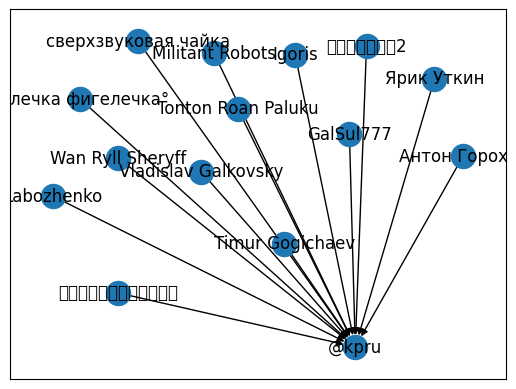

In [143]:
print("Visualizing a small subset of connections...")

nodes = list(G.nodes)

subgraph = G.subgraph(nodes[:15])

subgraph_pos = nx.spring_layout(subgraph)

# Layouts: https://networkx.org/documentation/stable/reference/drawing.html
nx.draw_networkx(subgraph, subgraph_pos)

<h2>Network Anslysis Questions:</h2>

1. How many connections are overlapping within each given group. (e.g. how
many people following SWJ also follow NYT)
2. How many overlaps are there in between clusters from different groups?

3. Do nodes cluster into tightly connected groups?

<h2>Network Visualization Questions</h2>

3. Visualize the connections in pretty way
4. Visualize Cluster sizes
5. Visualize groups by color coding them

<h2>Sentiment Analysis Questions</h2>
1. Word Cloud: what are people within each group discussing (Use entity recognition)?

2. Tag Cloud: who are people within each group discussing?

3. What sentiment do mentions within each groups have?

4. What is a general Twitter sentiment on this topic (Can use Ukraine dataset)

<h2>Visualization Techniques that can be leveraged</h2>
1. Network Visualization

2. Coloring nodes

3. Coloring Connections

4. Size of the nodes

5. Shape of the nodes


In [471]:
def get_edge_attributes(graph, attr_list):
    KEY = 0
    VALUE = 1
    edge_attrs = {}
    for attr in attr_list:
        edges_attribute = nx.get_edge_attributes(graph, attr)
        for edge_attr in edges_attribute.items():
            if edge_attr[KEY] in edge_attrs.keys():
                edge_attr_values = edge_attrs[edge_attr[KEY]]
                edge_attr_values.append(edge_attr[VALUE])
                edge_attrs[edge_attr[KEY]] = edge_attr_values
            else:
                edge_attrs[edge_attr[KEY]] = [edge_attr[VALUE]]
    return edge_attrs

edge_attrs = get_edge_attributes(subgraph, global_graph_pd_columns)

print(edge_attrs)

{('Igoris', '@kpru'): ['Igoris', 1600373113069371393, '@kpru', 40807205, 313456, 0], ('Labozhenko', '@kpru'): ['Labozhenko', 766163415417163776, '@kpru', 40807205, 313456, 0], ('幸慶美智子（安東美智子）', '@kpru'): ['幸慶美智子（安東美智子）', 146380164, '@kpru', 40807205, 313456, 0], ('Militant Robots', '@kpru'): ['Militant Robots', 38592593, '@kpru', 40807205, 313456, 0], ('Tonton Roan Paluku', '@kpru'): ['Tonton Roan Paluku', 1505630951111630851, '@kpru', 40807205, 313456, 0], ('Wan Ryll Sheryff', '@kpru'): ['Wan Ryll Sheryff', 1590519969267187712, '@kpru', 40807205, 313456, 0], ('°Элечка фигелечка°', '@kpru'): ['°Элечка фигелечка°', 1171442562625724416, '@kpru', 40807205, 313456, 0], ('Ярик Уткин', '@kpru'): ['Ярик Уткин', 1597537207702667270, '@kpru', 40807205, 313456, 0], ('Timur Gogichaev', '@kpru'): ['Timur Gogichaev', 1600363400072204288, '@kpru', 40807205, 313456, 0], ('Vladislav Galkovsky', '@kpru'): ['Vladislav Galkovsky', 1432890283, '@kpru', 40807205, 313456, 0], ('GalSul777', '@kpru'): ['GalSul

In [472]:
print("Running analysis on the network...")

# https://subscription.packtpub.com/book/big-data-and-business-intelligence/9781789955316/7

G.edges

Running analysis on the network...


OutEdgeView([('сверхзвуковая чайка', '@kpru'), ('GalSul777', '@kpru'), ('°Элечка фигелечка°', '@kpru'), ('Igoris', '@kpru'), ('Ярик Уткин', '@kpru'), ('幸慶美智子（安東美智子）', '@kpru'), ('Timur Gogichaev', '@kpru'), ('Tonton Roan Paluku', '@kpru'), ('山东挺郭小蚂蚁2', '@kpru'), ('山东挺郭小蚂蚁2', '@teamnavalny'), ('Wan Ryll Sheryff', '@kpru'), ('Labozhenko', '@kpru'), ('Vladislav Galkovsky', '@kpru'), ('Militant Robots', '@kpru'), ('Антон Горохов', '@kpru'), ('Бурановская бабушка', '@kpru'), ('Rinata', '@kpru'), ('GreenMan', '@kpru'), ('Окнини-сан', '@kpru'), ('Nazerke Turganbek', '@kpru'), ('Bella Cambodge', '@kpru'), ('Ильяс', '@kpru'), ('Leila Akhmetzhanova', '@kpru'), ('DASHA DO', '@kpru'), ('Kandaylet', '@kpru'), ('WagonMaster', '@kpru'), ('forest', '@kpru'), ('Sunflower', '@kpru'), ('Glasgow Science', '@kpru'), ('Glasgow Science', '@teamnavalny'), ('Фотік-котік', '@kpru'), ('Milorad Markovic', '@kpru'), ('DJ dozmix Guervil', '@kpru'), ('Andrii', '@kpru'), ('Andrii', '@EspresoTV'), ('Батько', '@kpru'),

In [473]:
subgraph.edges

OutEdgeView([('Igoris', '@kpru'), ('Labozhenko', '@kpru'), ('幸慶美智子（安東美智子）', '@kpru'), ('Militant Robots', '@kpru'), ('Tonton Roan Paluku', '@kpru'), ('Wan Ryll Sheryff', '@kpru'), ('°Элечка фигелечка°', '@kpru'), ('Ярик Уткин', '@kpru'), ('Timur Gogichaev', '@kpru'), ('Vladislav Galkovsky', '@kpru'), ('GalSul777', '@kpru'), ('Антон Горохов', '@kpru'), ('сверхзвуковая чайка', '@kpru'), ('山东挺郭小蚂蚁2', '@kpru')])

In [ ]:
# COMMUNITIES CAN BE CONSTRUCTED BY HAND BY MAKING COMMUNITY TO BE AN EDGE ATTRIBUTE

In [474]:
# probability some bad values are in dataframe that have incorrect type
# TODO: PERHAPS CREATE COMMUNITIES BY HAND, YOU KNOW WHAT THEY ARE

import networkx.algorithms.community as nxcom

# identifying communities within the network
twitter_communities = sorted(nxcom.greedy_modularity_communities(G,
                                                                 weight=None),
                             key=len,
                             reverse=True)

In [476]:
print("The number of communities detected is ", len(twitter_communities))

The number of communities detected is  4


In [487]:
print("The communities detected are ", twitter_communities[3])

The communities detected are  frozenset({'Liudmila Yasinskaya', 'Elnaik Elsouri', 'IRA', 'Shawna Anderson', 'Двоемыслитель', 'Konul Yusifqizi', 'ABetkhemyan', 'mmshjdb.he', 'Olena Dnipro', 'Vladislav Saakyants', 'v+', 'Maks Abdi', 'Rasulbek Polvanov', 'tcc', 'Harveer Singh', 'Белые ночи', 'DukeCristianFitzAzrobal1', 'Valentina Radchenko', 'Venice Queen', 'Milena Gevorgyan', 'Furkat', 'Takesh', 'Jonibek Axmadov', 'DAULET', 'Dani 🚿🚿🚿', 'Rodion Gaevoy', 'Shahboz Badiyev', 'Super Doge', 'HarryPapadopoulos', 'Leila Akhmetzhanova', 'Alexey Klopkov', 'Elina', 'Давид Айткалиев', 'Jackson B.O. Lock, BA', 'redred', 'Азамат', 'Dont let them fool you', 'stan karayan', 'AKBAR RIKHSIBOYEV', 'Светлана Svetla', 'Uivy', 'Justpage348', 'Renaud Geresi', 'Ellie', 'Хамза Шарипкулов', 'Vees', 'Muhammad Sʼabdullayev', 'Kochan', 'Emily Erickson', 'Furkat Kurbanov', 'катышки на трусах', 'Andres Balingit Fajardo #TrumpMarcosloyalists', 'Very_VellVL', 'Флора', 'Götz von Berlichingen', 'Murox tubolokmurox@gmail.c

In [477]:
print("Visualizing Identified Communities")

def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1

def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0

Visualizing Identified Communities


In [478]:
def get_color(i, r_off=1, g_off=1, b_off=1):
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

In [479]:
# Set node and edge communities
set_node_community(G, twitter_communities)
set_edge_community(G)

# Set community color for nodes
node_color = [
    get_color(G.nodes[v]['community'])
    for v in G.nodes]

# Set community color for internal edges
external = [
    (v, w) for v, w in G.edges
    if G.edges[v, w]['community'] == 0]

internal = [
    (v, w) for v, w in G.edges
    if G.edges[v, w]['community'] > 0]

internal_color = [
    get_color(G.edges[e]['community'])
    for e in internal]

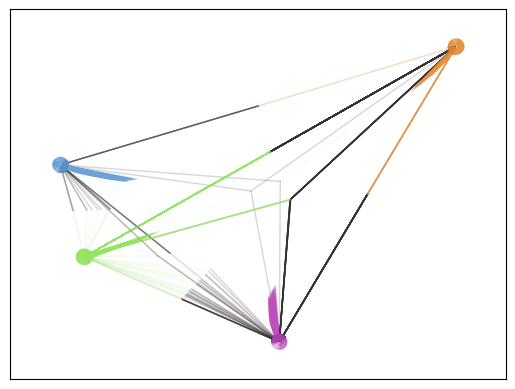

In [480]:
# Draw external edges
nx.draw_networkx(
    G, pos=pos, node_size=0,
    edgelist=external, edge_color="#333333",
    alpha=0.2, with_labels=False)

# Draw internal edges
nx.draw_networkx(
    G, pos=pos, node_size=0,
    edgelist=internal, edge_color=internal_color,
    alpha=0.05, with_labels=False)

In [149]:
all_clusters = []

all_clusters.extend(rus_cluster)
all_clusters.extend(ukr_eng_cluster)
all_clusters.extend(ukr_rus_cluster)
all_clusters.extend(ukr_ukr_cluster)

all_clusters_dict = {}

for cluster in all_clusters:
    if str(cluster[0]) in G.nodes:
        all_clusters_dict[str(cluster[0])] = str(cluster[0])

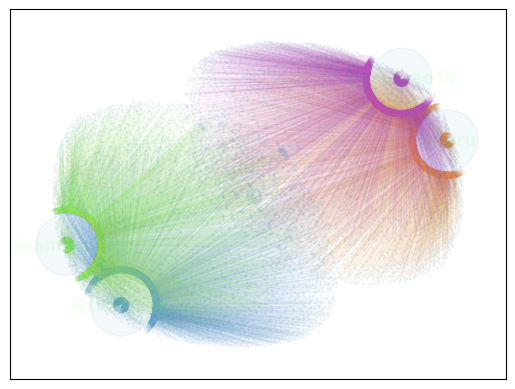

In [489]:
# TODO: SAVE AS PDF

pos = nx.spring_layout(G, k=0.15)

G_node_degrees = dict(G.degree)

# Draw internal edges
nx.draw_networkx(
    G, pos=pos, node_size=[v * 1 for v in G_node_degrees.values()],
    edgelist=internal, edge_color=internal_color,
    alpha=0.05, with_labels=True, label='Group Follower Clusters',
    labels=all_clusters_dict, font_color='#00ff00', font_weight='bold')

In [490]:
all_clusters_dict

{'@kpru': '@kpru',
 '@timkmak': '@timkmak',
 '@teamnavalny': '@teamnavalny',
 '@EspresoTV': '@EspresoTV'}

In [491]:
def sort_graph_by_deg_desc(graph):
    return sorted(G.degree, key=lambda x: x[1], reverse=True)

In [105]:
G_deg_sorted = sort_graph_by_deg_desc(G)

In [492]:
print("Performing connectivity analysis on a graph")

node_connections = nx.all_pairs_node_connectivity(subgraph)

Performing connectivity analysis on a graph


In [493]:
def get_shared_nodes_within_group(node_connections, group_members):
    shared_connections = []
    for username, connections_dict in node_connections.items():
        for group_member in group_members:
            if group_member in connections_dict.keys() and connections_dict[group_member] == 1:
                shared_connections.append(username)
    return shared_connections

In [494]:
get_shared_nodes_within_group(node_connections, rus_cluster)

[]

In [495]:
def get_shared_nodes_between_groups(node_connections, cluster_groups):
    shared_connections = {}
    for username, connections_dict in node_connections.items():
        for group_name, group_members in cluster_groups.items():
            for group_member in group_members:
                if group_member in connections_dict.keys() and connections_dict[group_member] == 1:
                    if group_name not in shared_connections.keys():
                        shared_connections.append(username)
                    else:
                        shared_connections[group_name] = shared_connections[group_name].append(username)
    return shared_connections

In [496]:
TWITTER_CLUSTER_GROUPS = {
    "rus_cluster": russia_sources_rus,
    "ukr_eng_cluster": ukraine_sources_rus,
    "ukr_rus_cluster": ukraine_sources_ukr,
    "ukr_ukr_cluster": ukraine_sources_eng
}

In [111]:
shared_connections_between_groups = get_shared_nodes_between_groups\
(node_connections, TWITTER_CLUSTER_GROUPS)

In [112]:
shared_connections_between_groups

{}

In [113]:
'''
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10, 10))
plt.style.use('ggplot')
nodes = nx.draw_networkx_nodes(G, pos,
                               alpha=0.8)
nodes.set_edgecolor('k')
nx.draw_networkx_labels(G, pos, font_size=8)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.2)
'''

"\nimport matplotlib.pyplot as plt\n\nf, ax = plt.subplots(figsize=(10, 10))\nplt.style.use('ggplot')\nnodes = nx.draw_networkx_nodes(G, pos,\n                               alpha=0.8)\nnodes.set_edgecolor('k')\nnx.draw_networkx_labels(G, pos, font_size=8)\nnx.draw_networkx_edges(G, pos, width=1.0, alpha=0.2)\n"

In [114]:
# TODO: analyze social network graph using NetworkX
# TODO: perhaps the network should be cleaned of low degree connected users
#  for visualization purposes
# TODO: run the graph analytics on the original network w/o visualizing it

In [115]:
# TODO: node size should correspond to the number of followers the node has
# TODO: node color should correspond to the node group

<h2>Analyzing group sentiments</h2>

In [65]:
# THIS CELL HITS TWITTER API

# NOTE: THIS FUNCTION PULLS THE TWEETS MENTIONING A PARTICULAR USER, NOT FROM
# A PARTICULAR USER

def get_user_tweet_mentions(username, num_tweets, entities=None):

    search_query = username + " OR "

    if entities is not None:
        # include all possible candidate names in a query
        for entity in entities:
            search_query += "entity:" + '"' + entity + '"' + " OR "

    # remove the last OR statement
    search_query = search_query[:-3]

    search_query += "-is:retweet"

    tweets = api.search_tweets(q = search_query, count = num_tweets,
                               tweet_mode="extended")

    return tweets

In [66]:
# THIS CELL HITS TWITTER API

def get_user_tweets(user_id, num_tweets):

    # https://docs.tweepy.org/en/stable/client.html#tweepy.Client.get_users_tweets
    # https://docs.tweepy.org/en/stable/expansions_and_fields.html#expansions-parameter
    # https://dev.to/twitterdev/a-comprehensive-guide-for-using-the-twitter-api-v2-using-tweepy-in-python-15d9

    tweets = client.get_users_tweets(id = user_id, max_results = num_tweets,
                               exclude = ['retweets'], expansions='entities.mentions.username')

    return tweets

In [79]:
# Sentiment in relation to a different group

# Tweets word Cloud

# Tweets HashTags Word Cloud

# Tweets events mapping? (Maybe)

In [80]:
# https://www.caida.org/catalog/software/walrus/

In [67]:
print("Pulling 100 recent tweets from Twitter for each cluster")

NUM_TWEETS = 100
USERNAME_IDX = 0
USER_ID_IDX = 1

rus_cluster_tweets = {}
ukr_eng_cluster_tweets = {}
ukr_rus_cluster_tweets = {}
ukr_ukr_cluster_tweets = {}

Pulling 100 recent tweets from Twitter for each cluster


In [68]:
LOAD_TWEETS = True

In [69]:
if not LOAD_TWEETS:
    print("Retrieving recent tweets from the rus_cluster")
    for cluster in rus_cluster:
        rus_cluster_tweets[cluster] = get_user_tweets(cluster[USER_ID_IDX], NUM_TWEETS)

In [70]:
len(rus_cluster_tweets)

0

In [71]:
if not LOAD_TWEETS:
    print("Retrieving recent tweets from the ukr_eng_cluster_tweets")
    for cluster in ukr_eng_cluster:
        ukr_eng_cluster_tweets[cluster] = get_user_tweets(cluster[USER_ID_IDX], NUM_TWEETS)

In [72]:
if not LOAD_TWEETS:
    print("Retrieving recent tweets from the ukr_rus_cluster_tweets")
    for cluster in ukr_rus_cluster:
        ukr_rus_cluster_tweets[cluster] = get_user_tweets(cluster[USER_ID_IDX], NUM_TWEETS)

In [73]:
if not LOAD_TWEETS:
    print("Retrieving recent tweets from the ukr_ukr_cluster_tweets")
    for cluster in ukr_ukr_cluster:
        ukr_ukr_cluster_tweets[cluster] = get_user_tweets(cluster[USER_ID_IDX], NUM_TWEETS)

In [74]:
def convert_tweets_to_json(raw_tweets_dict):
    json_tweets = []
    for username, tweets in raw_tweets_dict.items():
        for tweet in tweets:
            json_tweet_str = json.dumps(tweet.text)
            json_tweet = json.loads(json_tweet_str)
            json_tweets.append(json_tweet)
    return json_tweets

In [75]:
# TEST CODE
tweet_status = api.get_status(1598709448129662977)

print(tweet_status._json)

{'created_at': 'Fri Dec 02 16:03:29 +0000 2022', 'id': 1598709448129662977, 'id_str': '1598709448129662977', 'text': 'На канале "В гостях у Гордона" транслируется стрим главного редактора интернет-издания "#ГОРДОН" Алеси #Бацман с те… https://t.co/ta77zbvZLc', 'truncated': True, 'entities': {'hashtags': [{'text': 'ГОРДОН', 'indices': [88, 95]}, {'text': 'Бацман', 'indices': [103, 110]}], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/ta77zbvZLc', 'expanded_url': 'https://twitter.com/i/web/status/1598709448129662977', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}]}, 'source': '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 1334400780, 'id_str': '1334400780', 'name': 'Дмитрий Гордон', 'screen_name': 'dmitry_gordon', 'location': 'Украина', 'descri

In [76]:
TWEETS_DIR = 'tweets/'

def tweets_to_df(raw_tweets_dict):
    tweets_df = pd.DataFrame(
        {
            'Cluster Username' : pd.Series(dtype='str'),
            'Cluster ID' : pd.Series(dtype='int'),
            'Tweet Text' : pd.Series(dtype='str')
        }
    )
    for username, tweets in raw_tweets_dict.items():
            for tweet in tweets.data:
                new_df_row = {
                    'Cluster Username' : username[0],
                    'Cluster ID' : username[1],
                    'Tweet Text' : str(tweet)
                }
                tweets_df = tweets_df.append(new_df_row, ignore_index=True)
    return tweets_df

def tweets_df_to_csv(tweets_df, cluster_dir_name):
    print("Writing tweets for ", cluster_dir_name, " to a file")
    tweets_df.to_csv(TWEETS_DIR + cluster_dir_name + 'tweets.csv', index=False)
    return

In [77]:
TWEETS_CLUSTER_DIR = 'rus-rus-tweets/'

if not LOAD_TWEETS:
    rus_rus_tweets_df = tweets_to_df(rus_cluster_tweets)
    tweets_df_to_csv(rus_rus_tweets_df, TWEETS_CLUSTER_DIR)
else:
    rus_rus_tweets_df = pd.read_csv(TWEETS_DIR + TWEETS_CLUSTER_DIR + "tweets.csv")

In [78]:
TWEETS_CLUSTER_DIR = 'ukr-eng-tweets/'

if not LOAD_TWEETS:
    ukr_eng_tweets_df = tweets_to_df(ukr_eng_cluster_tweets)
    tweets_df_to_csv(ukr_eng_tweets_df, TWEETS_CLUSTER_DIR)
else:
    ukr_eng_tweets_df = pd.read_csv(TWEETS_DIR + TWEETS_CLUSTER_DIR + "tweets.csv")

In [79]:
TWEETS_CLUSTER_DIR = 'ukr-rus-tweets/'

if not LOAD_TWEETS:
    ukr_rus_tweets_df = tweets_to_df(ukr_rus_cluster_tweets)
    tweets_df_to_csv(ukr_rus_tweets_df, TWEETS_CLUSTER_DIR)
else:
    ukr_rus_tweets_df = pd.read_csv(TWEETS_DIR + TWEETS_CLUSTER_DIR + "tweets.csv")

In [80]:
TWEETS_CLUSTER_DIR = 'ukr-ukr-tweets/'

if not LOAD_TWEETS:
    ukr_ukr_tweets_df = tweets_to_df(ukr_ukr_cluster_tweets)
    tweets_df_to_csv(ukr_ukr_tweets_df, TWEETS_CLUSTER_DIR)
else:
    ukr_ukr_tweets_df = pd.read_csv(TWEETS_DIR + TWEETS_CLUSTER_DIR + "tweets.csv")

<h2>Processing Collected Tweets Before Visualizing them</h2>

In [81]:
print("Use this function to clean the tweet's body")

def clean_tweet(tweet_body):
    # remove @ mentions from the tweet
    # text = re.sub(r'@[A-Za-z0-9]+', '', tweet_body)
    # remove the hashtags from tweets
    # text = re.sub(r'#', '', text)
    # remove retweet
    text = re.sub(r'RT[\s]+', '', tweet_body)
    # remove hyperlinks
    text = re.sub(r'https?:\/\/\S+', '', text)
    return text

Use this function to clean the tweet's body


In [82]:
import string

def remove_ua_stopwords(tweet_body):
    stopwords_ua = pd.read_csv("stopwords_ua.txt", header=None, names=['stopwords'])
    stop_words_ua = list(stopwords_ua.stopwords)
    text = "".join([word for word in tweet_body if word not in string.punctuation])
    text = text.lower()
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stop_words_ua]
    return text

In [83]:
# this fucntion doesn't support Ukrainian

from nltk.corpus import stopwords

print("Supported langauges are: ")
print(stopwords.fileids())

def remove_stopwords(tweet_body, lang='english'):
    stop_words = set(stopwords.words(lang))
    word_tokens = nltk.word_tokenize(tweet_body)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    filtered_sentence =' '.join(filtered_sentence)
    return filtered_sentence

Supported langauges are: 
['arabic', 'azerbaijani', 'basque', 'bengali', 'catalan', 'chinese', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hebrew', 'hinglish', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


In [84]:
# TEST CODE
txt = "Засвідчивши свою відпускну в петербурзькій Палаті цивільного суду, Шевченко став учнем Академії мистецтв, де його наставником став К. Брюллов.[49] За словами Шевченка: «настала найсвітліша доба його життя, незабутні, золоті дні» навчання в Академії мистецтв, яким він присвятив у 1856 році автобіографічну повість «Художник»."

txt = remove_ua_stopwords(txt)

print(txt)

['засвідчивши', 'відпускну', 'петербурзькій', 'палаті', 'цивільного', 'суду', 'шевченко', 'учнем', 'академії', 'мистецтв', 'наставником', 'брюллов49', 'словами', 'шевченка', 'настала', 'найсвітліша', 'доба', 'життя', 'незабутні', 'золоті', 'дні', 'навчання', 'академії', 'мистецтв', 'присвятив', '1856', 'автобіографічну', 'повість', 'художник', '']


In [85]:
# TEST CODE

txt = "Окончательно фамилия «Достоевский» закрепилась за внуками Данилы Ивановича, потомки которых со временем становятся типичной служилой шляхтой[13][14]. Пинская ветвь Достоевских на протяжении почти двух веков упоминалась в различных документах, но со временем интегрировалась польско-литовским государством, утратив дворянство[15][16]. Во второй половине XVII века род перебирался на Украину. В это же время резко сократилось количество упоминаний фамилии в исторических документах[16]."

txt = remove_stopwords(txt, lang='russian')

print(txt)

Окончательно фамилия « Достоевский » закрепилась внуками Данилы Ивановича , потомки которых временем становятся типичной служилой шляхтой [ 13 ] [ 14 ] . Пинская ветвь Достоевских протяжении двух веков упоминалась различных документах , временем интегрировалась польско-литовским государством , утратив дворянство [ 15 ] [ 16 ] . второй половине XVII века род перебирался Украину . это время резко сократилось количество упоминаний фамилии исторических документах [ 16 ] .


In [86]:
# to be used for word cloud creation
def get_cleaned_tokens(tweets_df, lang='english'):
    tweet_tokens_dict = {}

    for _, row in tweets_df.iterrows():
        tweet_text = row['Tweet Text']
        tweet_text = clean_tweet(tweet_text)
        # remove the stopwords
        if lang == 'ukrainian':
            tweet_text = remove_ua_stopwords(tweet_text)
            tweet_text = ' '.join(tweet_text)
        else:
            tweet_text = remove_stopwords(tweet_text, lang=lang)

        tokenized_tweet = nltk.word_tokenize(tweet_text)
        if row['Cluster Username'] in tweet_tokens_dict.keys():
            tweet_tokens_dict[row['Cluster Username']].extend(tokenized_tweet)
        else:
            tweet_tokens_dict[row['Cluster Username']] = tokenized_tweet

    return tweet_tokens_dict

<h2>Visualizing Tweet Content using Word Cloud</h2>

In [87]:
# potential problem: @rt_com propagandist source publishing tweets in english

rus_rus_tweets_dict_tokens = get_cleaned_tokens(rus_rus_tweets_df,
                                               lang='russian')
ukr_eng_tweets_dict_tokens = get_cleaned_tokens(ukr_eng_tweets_df,
                                               lang='english')
ukr_rus_tweets_dict_tokens = get_cleaned_tokens(ukr_rus_tweets_df,
                                               lang='russian')
ukr_ukr_tweets_dict_tokens = get_cleaned_tokens(ukr_ukr_tweets_df,
                                              lang='ukrainian')

In [88]:
ukr_ukr_tweets_dict_tokens.keys()

dict_keys(['@HromadskeUA', '@tsnua', '@24tvua', '@unian', '@radiosvoboda', '@5channel', '@EspresoTV'])

In [89]:
# NOTE: wordcloud per cluster, not per group

def create_cluster_wordcloud(tweets_dict_tokens, cluster_name):
    tweet_word_cloud = WordCloud(random_state=21,
                           max_font_size=119).generate(' '.join(tweets_dict_tokens[cluster_name]))
    plt.figure(figsize=(20,10))
    plt.imshow(tweet_word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    return

In [90]:
# NOTE: wordcloud per cluster, not per group

def create_group_wordcloud(tweets_dict_tokens,saved_file_name):

    FIG_DIR = "visualizations/"

    tweets_text = ''

    for cluster_name in tweets_dict_tokens.keys():
        tweets_text += ' '.join(tweets_dict_tokens[cluster_name])

    tweet_word_cloud = WordCloud(random_state=21,
                           max_font_size=119).generate(tweets_text)

    plt.figure(figsize=(20,10))
    plt.imshow(tweet_word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(FIG_DIR + saved_file_name, format='pdf')
    plt.show()
    return plt

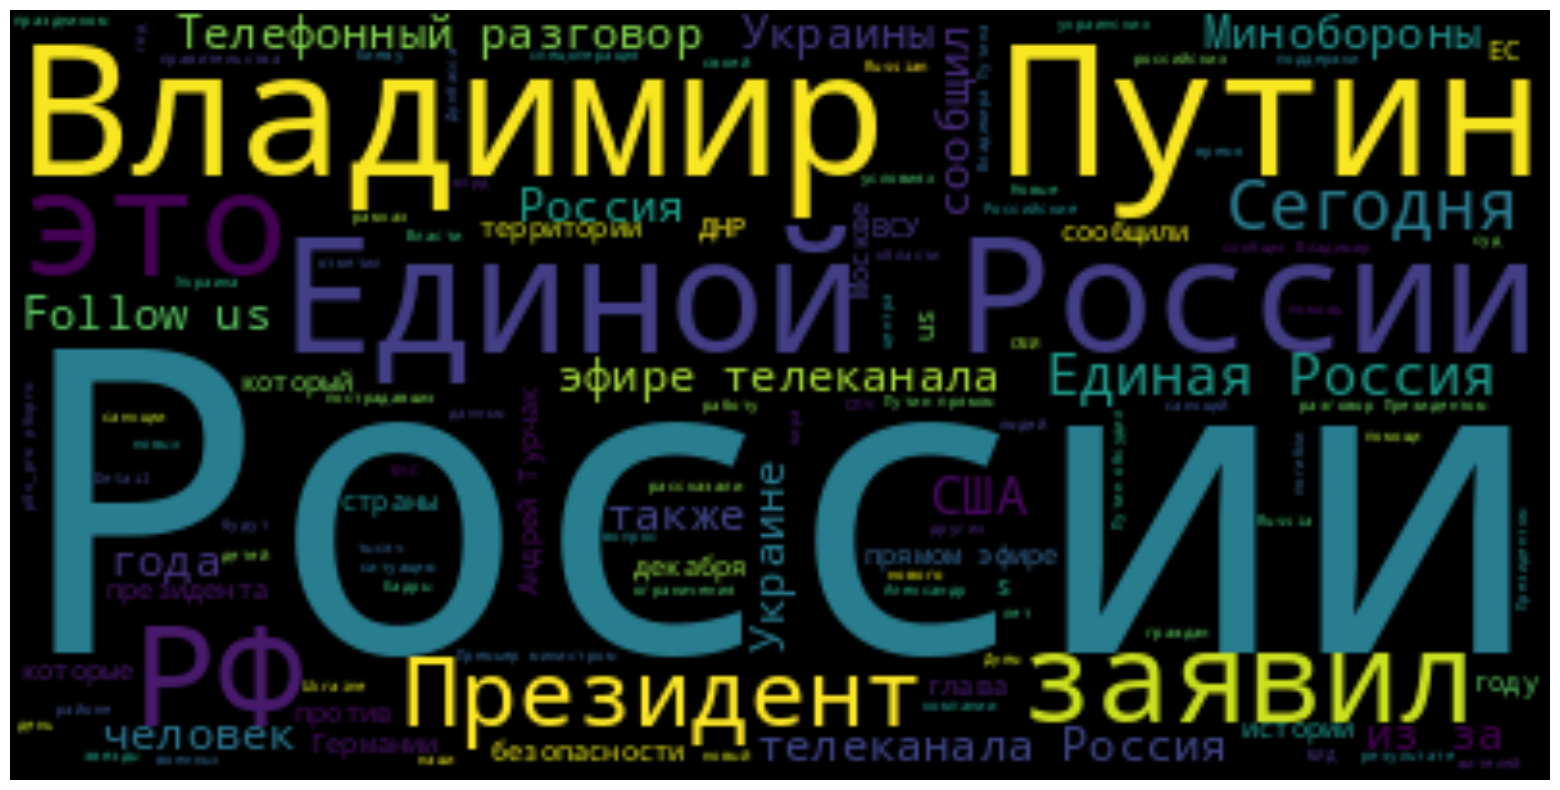

<module 'matplotlib.pyplot' from '/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [91]:
create_group_wordcloud(rus_rus_tweets_dict_tokens, "rus_rus_tweets_cloud")

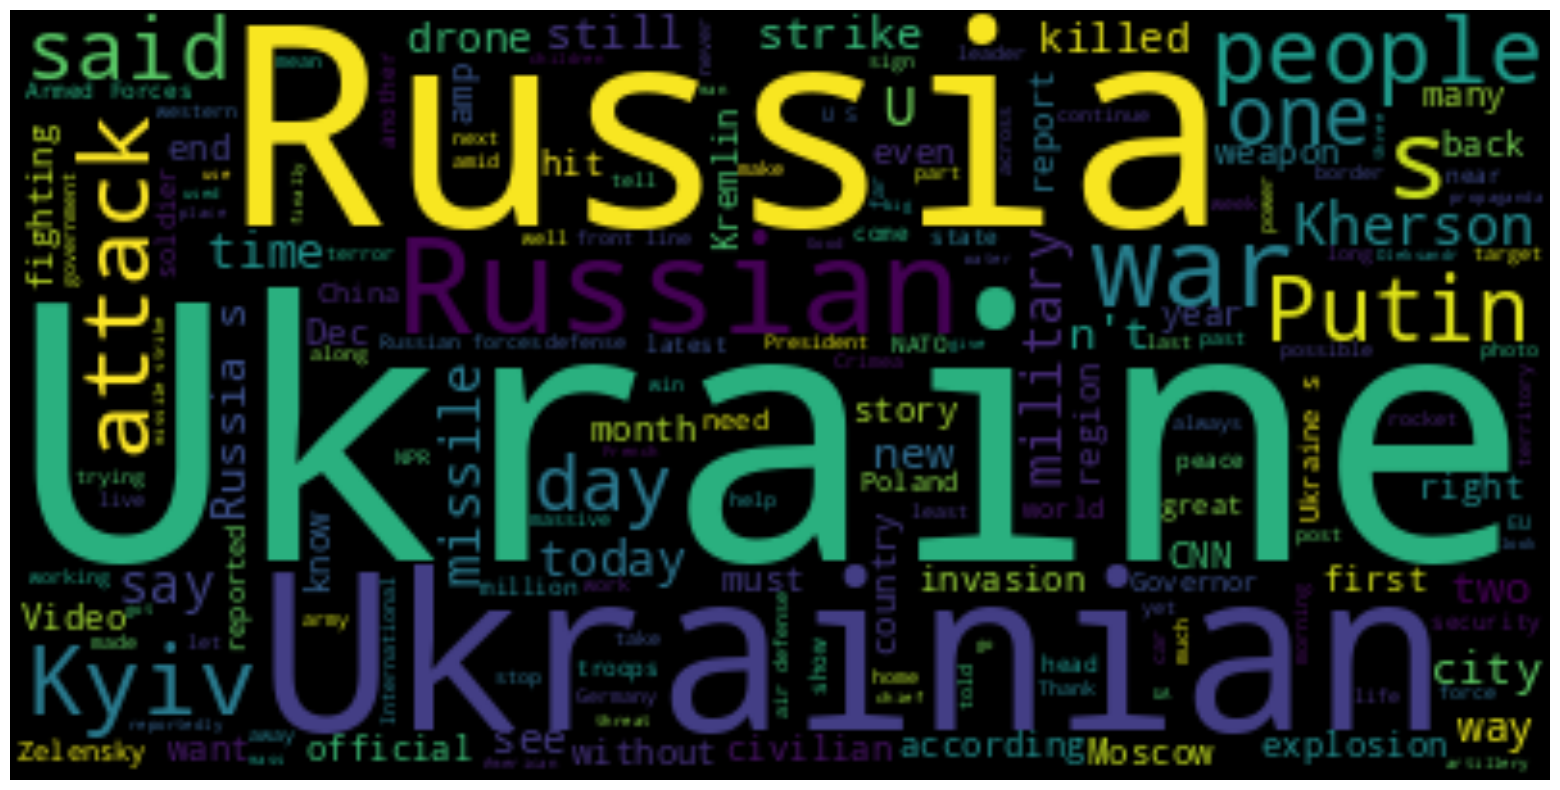

<module 'matplotlib.pyplot' from '/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [92]:
create_group_wordcloud(ukr_eng_tweets_dict_tokens, "ukr_eng_tweets_cloud")

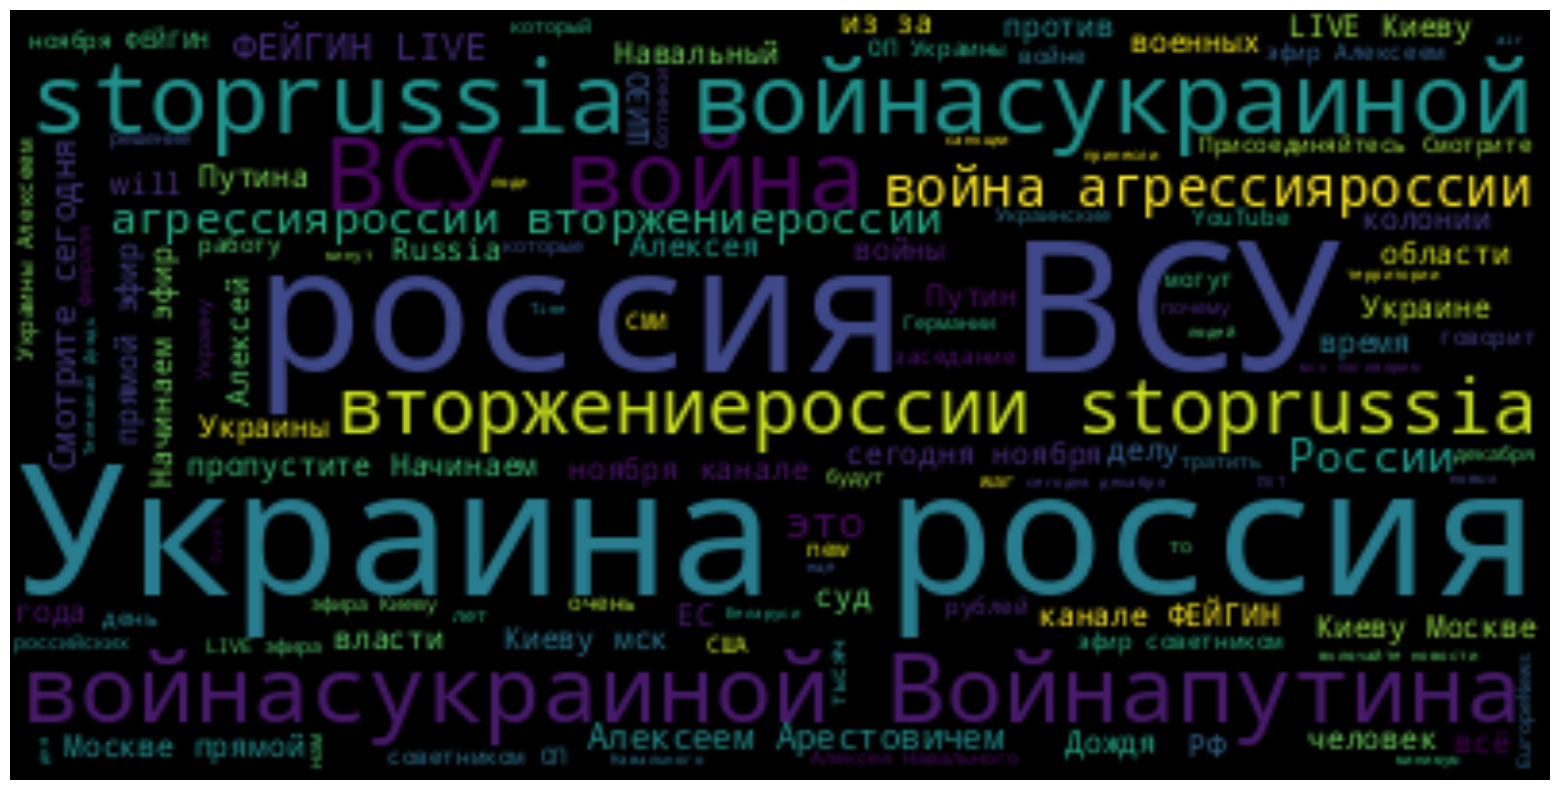

<module 'matplotlib.pyplot' from '/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [93]:
create_group_wordcloud(ukr_rus_tweets_dict_tokens, "ukr_rus_tweets_cloud")

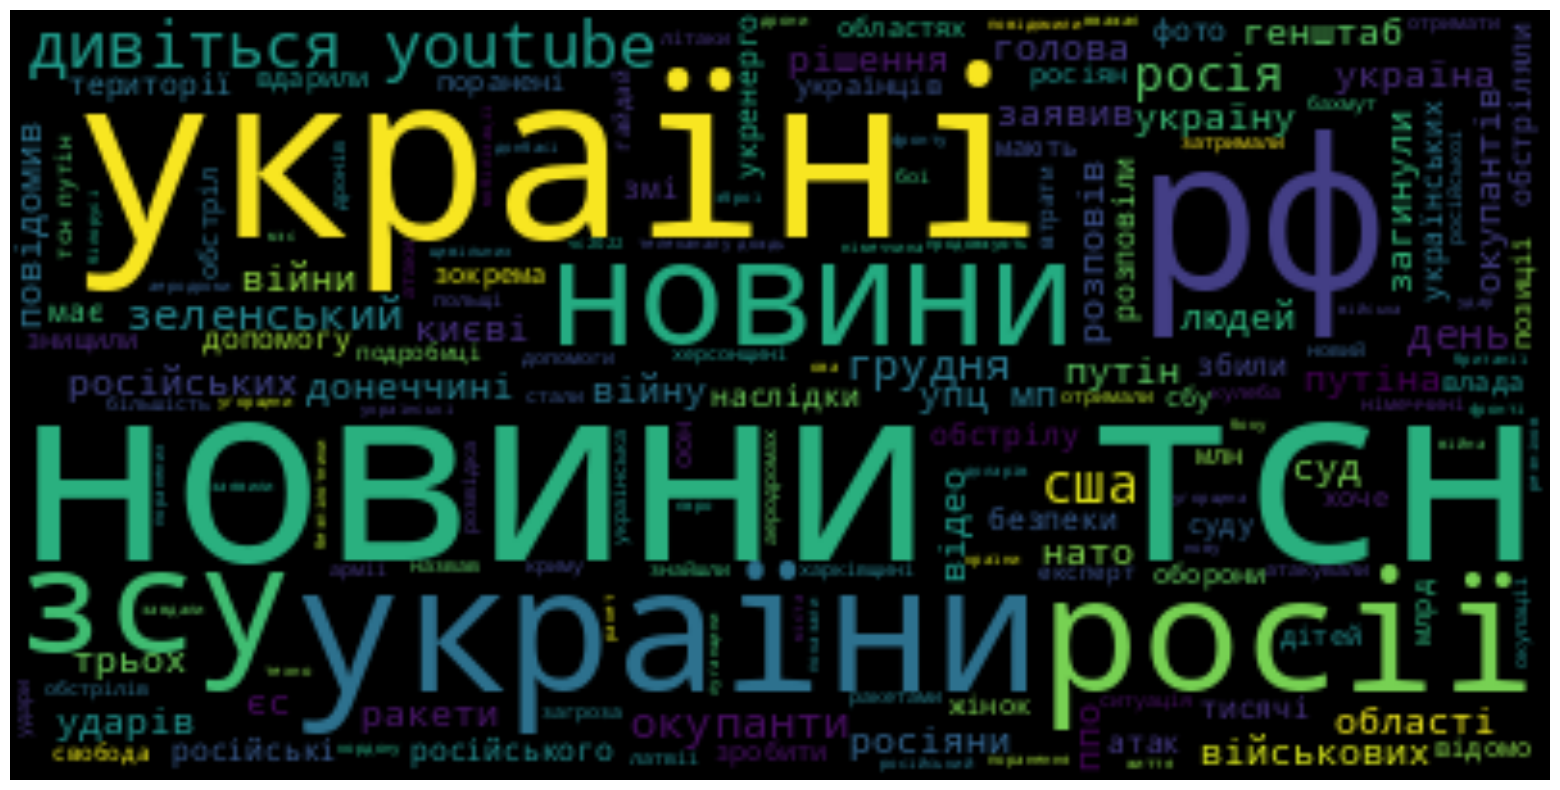

<module 'matplotlib.pyplot' from '/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [94]:
create_group_wordcloud(ukr_ukr_tweets_dict_tokens, "ukr_ukr_tweets_cloud")

<h2>Performing Entity Recognition and Sentiment Analysis for different
groups of tweets</h2>

In [583]:
print("Loading NLP libraries for English, Ukrainian and Russian languages")

Loading NLP libraries for English, Ukrainian and Russian languages


In [584]:
!python3 -m spacy download en_core_web_sm

nlp_eng = spacy.load('en_core_web_sm')

     |████████████████████████████████| 12.8 MB 9.1 MB/s            
You should consider upgrading via the '/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/bin/python3 -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [585]:
!python3 -m spacy download uk_core_news_sm

nlp_ukr = spacy.load('uk_core_news_sm')

     |████████████████████████████████| 14.9 MB 6.2 MB/s            
You should consider upgrading via the '/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/bin/python3 -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('uk_core_news_sm')


In [586]:
!python3 -m spacy download ru_core_news_sm

nlp_rus = spacy.load('ru_core_news_sm')

     |████████████████████████████████| 15.3 MB 8.2 MB/s            ██████████████████████          | 10.5 MB 6.4 MB/s eta 0:00:01
You should consider upgrading via the '/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/bin/python3 -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [587]:
# TEST CODE

# Spacy has vocabulary for English, Ukrainian and Russian languages

text = ("Восемь вандалов, которые срезали со стены дома в #Гостомеле женщину "
        "в противогазе авторства #Бэнкси, дали показания полиции #Украина #россия #ВСУ #война #агрессияроссии #вторжениероссии #stoprussia # #войнасукраиной #Войнапутина")

doc = nlp_rus(text)

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text)
    print(entity.text, entity.label_)

Гостомеле
Гостомеле PER
Бэнкси
Бэнкси PER
Украина
Украина LOC
ВСУ
ВСУ ORG


In [588]:
# TEST CODE

print("Performing sentiment analysis on tweets")

analyzer = SentimentIntensityAnalyzer()

analyzer.polarity_scores("Вейдер очень умный, красивый и смешной!!!")

Performing sentiment analysis on tweets


{'neg': 0.0, 'neu': 0.281, 'pos': 0.719, 'compound': 0.882}

In [589]:
# TEST CODE

analyzer.polarity_scores("Новый ракетный удар по мирным жителям Донецка. В сети публикуют момент атаки. Украинские боевики открыли огонь по многоэтажке. Прямое попадание реактивного снаряда. Взрывной волной выбило стекла в соседних зданиях. Два человека погибли https://t.co/xUgOmV4iWN https://t.co/hN8uLeHwzu")

{'neg': 0.234, 'neu': 0.766, 'pos': 0.0, 'compound': -0.9042}

<h2>Performing Entity and Sentiment Analysis</h2>

In [95]:
def augment_entity_to_df(tweets_df, lang='english'):

    new_df = tweets_df.copy(deep=True)

    entities_col = []

    for _, row in tweets_df.iterrows():
        entities = []
        tweet_text = row['Tweet Text']
        tweet_text = clean_tweet(tweet_text)
        if lang == 'english':
            nlp_doc = nlp_eng(tweet_text)
        elif lang == 'russian':
            nlp_doc = nlp_rus(tweet_text)
        elif lang == 'ukrainian':
            nlp_doc = nlp_ukr(tweet_text)
        else: raise Exception('Language not supported.')

        # NOTE: enteteties can be filtered based on the entity. e.g. only
        # people
        for entity in nlp_doc.ents:
            entities.append(entity.text)

        entities = list(set(entities))

        entities_col.append(entities)

    new_df['Entities'] = entities_col

    return new_df

In [96]:
rus_rus_entity_aug_df = augment_entity_to_df(rus_rus_tweets_df, lang='russian')

NameError: name 'nlp_rus' is not defined

In [ ]:
ukr_eng_entity_aug_df = augment_entity_to_df(ukr_eng_tweets_df, lang='english')

In [ ]:
ukr_rus_entity_aug_df = augment_entity_to_df(ukr_rus_tweets_df, lang='russian')

In [616]:
ukr_ukr_entity_aug_df = augment_entity_to_df(ukr_ukr_tweets_df, lang='ukrainian')

In [617]:
ukr_ukr_entity_aug_df.head()

Cluster Username  Cluster ID  \
0     @HromadskeUA  1454734730   
1     @HromadskeUA  1454734730   
2     @HromadskeUA  1454734730   
3     @HromadskeUA  1454734730   
4     @HromadskeUA  1454734730   

                                          Tweet Text  \
0  Зеленський заявив, що наразі неможливо віднови...   
1  Німеччина передала Україні ще 50 бронеавтомобі...   
2  Мер Чернігова Атрошенко звинуватив представник...   
3  Комітет Сенату США із міжнародних відносин схв...   
4  Комітет Сенату США схвалив резолюцію, яка визн...   

                                   Entities  
0                                        []  
1       [Україні, Німеччина, M1079 Oshkosh]  
2  [Чернігова, Офісу президента, Атрошенко]  
3       [Комітет Сенату США, Сенаті, росії]  
4       [Комітет Сенату США, Сенаті, росії]

In [97]:
def augment_sent_to_df(tweets_df, lang='english'):

    new_df = tweets_df.copy(deep=True)

    analyzer = SentimentIntensityAnalyzer()

    neg_sent = []
    pos_sent = []

    for _, row in tweets_df.iterrows():
        tweet_text = row['Tweet Text']
        tweet_text = clean_tweet(tweet_text)
        try:
            tweet_sentiment_scores = analyzer.polarity_scores(tweet_text)
            neg_sent.append(tweet_sentiment_scores['neg'])
            pos_sent.append(tweet_sentiment_scores['pos'])
        except IndexError:
            neg_sent.append(0)
            pos_sent.append(0)

    new_df['Neg'] = neg_sent
    new_df['Pos'] = pos_sent

    return new_df

In [111]:
def augment_num_followers_to_df(tweets_df, follower_count_dict):

   new_df = tweets_df.copy(deep=True)

   follower_count = []

   for _, row in tweets_df.iterrows():
       follower_count.append(follower_count_dict[row['Cluster ID']])

   new_df['cluster_follower_count'] = follower_count

   return new_df

In [99]:
print("Writing tweet-sentiment-entity dfs to a file")

TWEET_SENT_ENTITY_DIR = 'tweet-sentiment-entity/'

def save_tweet_sentiment_entity_df(tweet_sentiment_entity_df, file_name):
    tweet_sentiment_entity_df.to_csv(TWEET_SENT_ENTITY_DIR + file_name + ''
                                                                         '.csv', index=False)
    return

Writing tweet-sentiment-entity dfs to a file


In [100]:
def load_tweet_sentiment_entity_df(file_name):
    tweets_df = pd.read_csv(TWEET_SENT_ENTITY_DIR + file_name + '.csv')
    return tweets_df

In [101]:
rus_rus_entity_aug_df = load_tweet_sentiment_entity_df('rus_rus_entity_aug_df')
ukr_eng_entity_aug_df = load_tweet_sentiment_entity_df('ukr_eng_entity_aug_df')
ukr_rus_entity_aug_df = load_tweet_sentiment_entity_df('ukr_rus_entity_aug_df')
ukr_ukr_entity_aug_df = load_tweet_sentiment_entity_df('ukr_ukr_entity_aug_df')

In [596]:
print("Augmenting sentiment scores for all clusters")
rus_rus_entity_aug_df = augment_sent_to_df(rus_rus_entity_aug_df, lang='russian')

Augmenting sentiment scores for all clusters


IndexError: list index out of range

In [102]:
rus_rus_entity_aug_df.head()

Cluster Username  Cluster ID  \
0      @1tvru_news   160881696   
1      @1tvru_news   160881696   
2      @1tvru_news   160881696   
3      @1tvru_news   160881696   
4      @1tvru_news   160881696   

                                          Tweet Text  \
0  На передовой всегда есть место подвигу, и отли...   
1  И еще о подвигах наших героев — защитников Дон...   
2  Для киевских радикалов словосочетание «права ч...   
3  «Разговоры о каких-то дополнительных мобилизац...   
4  Орденом Мужества посмертно награждена депутат ...   

                                            Entities    Neg    Pos  
0                                                 []  0.055  0.063  
1                                       ['Донбасса']  0.154  0.266  
2                           ['Следственный комитет']  0.079  0.000  
3                                          ['Путин']  0.077  0.052  
4  ['Донецка', 'Мария Пирогова', 'ДНР', 'Кремля',...  0.079  0.130

In [627]:
ukr_eng_entity_aug_df = augment_sent_to_df(ukr_eng_entity_aug_df, lang='english')

In [121]:
ukr_eng_entity_aug_df.head()

Cluster Username  Cluster ID  \
0       @mschwirtz    29478953   
1       @mschwirtz    29478953   
2       @mschwirtz    29478953   
3       @mschwirtz    29478953   
4       @mschwirtz    29478953   

                                          Tweet Text  \
0  @LorenCrowe @RWApodcast It held strategic valu...   
1  Russia’s president, Vladimir Putin, signed a l...   
2  On patrol in eastern Ukraine one year ago toda...   
3  Read our 2015 report here https://t.co/HTkdvQIrAj   
4  Behind the scenes, Gov Andrew Cuomo’s administ...   

                                            Entities    Neg    Pos  
0  ['Bakhmut', 'Russian', 'Kramatorsk', 'Slovyans...  0.134  0.093  
1  ['Moscow', 'today', '2009', 'LGBT', 'Russia', ...  0.135  0.057  
2  ['one year ago', 'Russian', 'Ukraine', 'Avdiiv...  0.000  0.045  
3                                           ['2015']  0.000  0.000  
4        ['the day', 'Gov Andrew Cuomo’s', 'months']  0.218  0.000

In [599]:
ukr_rus_entity_aug_df = augment_sent_to_df(ukr_rus_entity_aug_df, lang='russian')

In [122]:
ukr_rus_entity_aug_df.head()

Cluster Username  Cluster ID  \
0   @dmitry_gordon  1334400780   
1   @dmitry_gordon  1334400780   
2   @dmitry_gordon  1334400780   
3   @dmitry_gordon  1334400780   
4   @dmitry_gordon  1334400780   

                                          Tweet Text  \
0  1888 украинских городов и сел уже удалось осво...   
1  Евросоюзу следует ввести санкции против всего,...   
2  В Херсонской области на каскаде мин погибли на...   
3  "Еще Петр I боролся". Путин назвал "присоедине...   
4  Госбюро расследований подтвердило, что суд отс...   

                                            Entities    Neg    Pos  
0                                      ['Зеленский']  0.000  0.057  
1                            ['Евросоюзу', 'России']  0.128  0.000  
2  ['ГУ', 'Нацполиции', 'Херсонской области', 'Че...  0.200  0.000  
3             ['Путин', 'России', 'Петр I', 'Офисе']  0.064  0.186  
4                 ['Чернигова Атрошенко', 'Госбюро']  0.000  0.000

In [618]:
ukr_ukr_entity_aug_df = augment_sent_to_df(ukr_ukr_entity_aug_df, lang='ukrainian')

In [631]:
ukr_ukr_entity_aug_df.head()

Cluster Username  Cluster ID  \
0     @HromadskeUA  1454734730   
1     @HromadskeUA  1454734730   
2     @HromadskeUA  1454734730   
3     @HromadskeUA  1454734730   
4     @HromadskeUA  1454734730   

                                          Tweet Text  \
0  Зеленський заявив, що наразі неможливо віднови...   
1  Німеччина передала Україні ще 50 бронеавтомобі...   
2  Мер Чернігова Атрошенко звинуватив представник...   
3  Комітет Сенату США із міжнародних відносин схв...   
4  Комітет Сенату США схвалив резолюцію, яка визн...   

                                   Entities    Neg    Pos  
0                                        []  0.066  0.114  
1       [Україні, Німеччина, M1079 Oshkosh]  0.000  0.000  
2  [Чернігова, Офісу президента, Атрошенко]  0.211  0.000  
3       [Комітет Сенату США, Сенаті, росії]  0.000  0.083  
4       [Комітет Сенату США, Сенаті, росії]  0.000  0.091

In [132]:
global_graph_pd.head()

username              user_id cluster_name cluster_id  \
0  сверхзвуковая чайка  1595723584277716994        @kpru   40807205   
1            GalSul777  1583541994059694087        @kpru   40807205   
2   °Элечка фигелечка°  1171442562625724416        @kpru   40807205   
3               Igoris  1600373113069371393        @kpru   40807205   
4           Ярик Уткин  1597537207702667270        @kpru   40807205   

  cluster_follow_count group_id  
0               313474        0  
1               313474        0  
2               313474        0  
3               313474        0  
4               313474        0

In [109]:
all_clusters = []
all_clusters.extend(russia_sources_rus)
all_clusters.extend(ukraine_sources_rus)
all_clusters.extend(ukraine_sources_ukr)
all_clusters.extend(ukraine_sources_eng)

def get_cluster_follow_count(clusters):
    cluster_followers = {}
    for cluster in clusters:
        cluster_followers[cluster[1]] = get_user_follower_count(cluster[1])
    return cluster_followers

In [110]:
all_cluster_followers = {}

all_cluster_followers = get_cluster_follow_count(all_clusters)

In [108]:
all_cluster_followers

Cluster Username  Cluster ID  \
0        @1tvru_news   160881696   
1        @1tvru_news   160881696   
2        @1tvru_news   160881696   
3        @1tvru_news   160881696   
4        @1tvru_news   160881696   
..               ...         ...   
890            @kpru    40807205   
891            @kpru    40807205   
892            @kpru    40807205   
893            @kpru    40807205   
894            @kpru    40807205   

                                            Tweet Text  \
0    На передовой всегда есть место подвигу, и отли...   
1    И еще о подвигах наших героев — защитников Дон...   
2    Для киевских радикалов словосочетание «права ч...   
3    «Разговоры о каких-то дополнительных мобилизац...   
4    Орденом Мужества посмертно награждена депутат ...   
..                                                 ...   
890  В подмосковной Балашихе мужчина совершает проб...   
891  Подозреваемые в подготовке государственного пе...   
892  В Санкт-Петербурге пройдет лекция в поддержку ...   
893  Йенс Столтенберг считает, условия для проведен...   
894  Как уйдет ковид: три возможных пути избавления...   

                                              Entities    Neg    Pos  
0                                                   []  0.055  0.063  
1                                         ['Донбасса']  0.154  0.266  
2                             ['Следственный комитет']  0.079  0.000  
3                                            ['Путин']  0.077  0.052  
4    ['Донецка', 'Мария Пирогова', 'ДНР', 'Кремля',...  0.079  0.130  
..                                                 ...    ...    ...  
890                                       ['Балашихе']  0.080  0.000  
891    ['России', 'Генпрокуратуре', 'ФРГ', 'Германии']  0.100  0.000  
892                               ['Санкт-Петербурге']  0.000  0.261  
893  ['Йенс Столтенберг', 'Киевом', 'Москвой', 'Укр...  0.000  0.263  
894                                                 []  0.000  0.000  

[895 rows x 6 columns]

In [112]:
# It seems to be too computationally expensive
print("Augmenting number of cluster followers to the data frame")

rus_rus_entity_aug_df = augment_num_followers_to_df(rus_rus_entity_aug_df, all_cluster_followers)

Augmenting number of cluster followers to the data frame


In [113]:
rus_rus_entity_aug_df.head()

Cluster Username  Cluster ID  \
0      @1tvru_news   160881696   
1      @1tvru_news   160881696   
2      @1tvru_news   160881696   
3      @1tvru_news   160881696   
4      @1tvru_news   160881696   

                                          Tweet Text  \
0  На передовой всегда есть место подвигу, и отли...   
1  И еще о подвигах наших героев — защитников Дон...   
2  Для киевских радикалов словосочетание «права ч...   
3  «Разговоры о каких-то дополнительных мобилизац...   
4  Орденом Мужества посмертно награждена депутат ...   

                                            Entities    Neg    Pos  \
0                                                 []  0.055  0.063   
1                                       ['Донбасса']  0.154  0.266   
2                           ['Следственный комитет']  0.079  0.000   
3                                          ['Путин']  0.077  0.052   
4  ['Донецка', 'Мария Пирогова', 'ДНР', 'Кремля',...  0.079  0.130   

   cluster_follower_count  
0                  427935  
1                  427935  
2                  427935  
3                  427935  
4                  427935

In [115]:
ukr_eng_entity_aug_df = augment_num_followers_to_df(ukr_eng_entity_aug_df, all_cluster_followers)
ukr_rus_entity_aug_df = augment_num_followers_to_df(ukr_rus_entity_aug_df, all_cluster_followers)
ukr_ukr_entity_aug_df = augment_num_followers_to_df(ukr_ukr_entity_aug_df, all_cluster_followers)

In [116]:
ukr_rus_entity_aug_df.head()

Cluster Username  Cluster ID  \
0   @dmitry_gordon  1334400780   
1   @dmitry_gordon  1334400780   
2   @dmitry_gordon  1334400780   
3   @dmitry_gordon  1334400780   
4   @dmitry_gordon  1334400780   

                                          Tweet Text  \
0  1888 украинских городов и сел уже удалось осво...   
1  Евросоюзу следует ввести санкции против всего,...   
2  В Херсонской области на каскаде мин погибли на...   
3  "Еще Петр I боролся". Путин назвал "присоедине...   
4  Госбюро расследований подтвердило, что суд отс...   

                                            Entities    Neg    Pos  \
0                                      ['Зеленский']  0.000  0.057   
1                            ['Евросоюзу', 'России']  0.128  0.000   
2  ['ГУ', 'Нацполиции', 'Херсонской области', 'Че...  0.200  0.000   
3             ['Путин', 'России', 'Петр I', 'Офисе']  0.064  0.186   
4                 ['Чернигова Атрошенко', 'Госбюро']  0.000  0.000   

   cluster_follower_count  
0                  155540  
1                  155540  
2                  155540  
3                  155540  
4                  155540

In [117]:
save_tweet_sentiment_entity_df(rus_rus_entity_aug_df, 'rus_rus_entity_aug_df')
save_tweet_sentiment_entity_df(ukr_eng_entity_aug_df, 'ukr_eng_entity_aug_df')
save_tweet_sentiment_entity_df(ukr_rus_entity_aug_df, 'ukr_rus_entity_aug_df')
save_tweet_sentiment_entity_df(ukr_ukr_entity_aug_df, 'ukr_ukr_entity_aug_df')

<h2>Creating Sentiment Visualizations in Plotly</h2>

In [136]:
FIGURES_DIR = 'visualizations/'

def write_figures_to_file(fig, fig_name, file_format):
    fig.write_image(FIGURES_DIR + fig_name + '.' + file_format)
    return

In [137]:
def plot_twitter_sent_fig(tweets_df, vis_name):
    tweet_sent_fig = px.scatter(tweets_df, x="Pos", y="Neg",
                            color="Cluster Username",
                            size="cluster_follower_count",
                            hover_data=['Entities'])

    save_fig_as_html(tweet_sent_fig, vis_name)
    write_figures_to_file(tweet_sent_fig, vis_name, 'pdf')
    tweet_sent_fig.show()
    return

In [138]:
plot_twitter_sent_fig(rus_rus_entity_aug_df, "rus_rus_sent_entity")

In [139]:
plot_twitter_sent_fig(ukr_eng_entity_aug_df, "ukr_eng_entity_aug_df")

In [140]:
plot_twitter_sent_fig(ukr_rus_entity_aug_df, "ukr_rus_entity_aug_df")

In [141]:
plot_twitter_sent_fig(ukr_ukr_entity_aug_df, "ukr_ukr_entity_aug_df")

<h2>Visualizing Network Graph using NetworkX and Bokeh</h2>

https://melaniewalsh.github.io/Intro-Cultural-Analytics/06-Network-Analysis/02-Making-Network-Viz-with-Bokeh.html

In [144]:
# creating a copy of the original network G

G_vis = G.copy()

In [145]:
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, EdgesAndLinkedNodes, NodesAndLinkedEdges
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8
from bokeh.transform import linear_cmap
from networkx.algorithms import community

In [146]:
modularity_class = dict(zip(global_graph_pd.username,
                                            global_graph_pd.group_id))

modularity_color = {}

for username, group_id in modularity_class.items():
    modularity_color[username] = Spectral8[group_id]

In [147]:
# Add modularity class and color as attributes from the network above
cluster_name_follower_count_dict = dict(zip(global_graph_pd.cluster_name,
                                            global_graph_pd.cluster_follow_count))

nx.set_node_attributes(G_vis, modularity_class, 'modularity_class')
nx.set_node_attributes(G_vis, modularity_color, 'modularity_color')
# nx.set_node_attributes(G_vis, name='cluster_name_follower_count_dict',
#                        values=cluster_name_follower_count_dict)

In [150]:
# make clusters bigger in size

node_sizes = {}

for node in G_vis.nodes:
    if node in all_clusters_dict.keys():
        node_sizes[node] = 20
    else:
        node_sizes[node] = 5

In [151]:
nx.set_node_attributes(G_vis, name='node_size',
                       values=node_sizes)

In [159]:
from bokeh.models import EdgesAndLinkedNodes, NodesAndLinkedEdges

#Choose colors for node and edge highlighting
node_highlight_color = 'white'
edge_highlight_color = 'black'

#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed

size_by_this_attribute = 'node_size'
color_by_this_attribute = 'modularity_color'

#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Blues8

#Choose a title!
title = 'Twitter Social Media Network'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [
        ("Username", "@index"),
        ("Follower count", "@cluster_name_follower_count_dict"),
        ("Cluster Class", "@modularity_class"),
        ("Cluster Color", "$color[swatch]:modularity_color"),
]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(G_vis, nx.spring_layout, scale=10, center=(0,0),
                              k=0.02)

#Set node sizes and colors according to node degree (color as category from attribute)
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=color_by_this_attribute)
# network_graph.node_renderer.glyph = Circle(fill_color=color_by_this_attribute)

#Set node highlight colors
# network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)
network_graph.node_renderer.hover_glyph = Circle(fill_color=node_highlight_color, line_width=2)

# network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)
network_graph.node_renderer.selection_glyph = Circle(fill_color=node_highlight_color, line_width=2)

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1,
                                              line_color='grey')
#Set edge highlight colors
network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)
network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)

#Highlight nodes and edges
network_graph.selection_policy = NodesAndLinkedEdges()
network_graph.inspection_policy = NodesAndLinkedEdges()

plot.renderers.append(network_graph)

In [160]:
show(plot)

In [161]:
save(plot, filename=f"{title}.html")

/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/lib/python3.7/site-packages/bokeh/io/saving.py:142: UserWarning:

save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN

/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/lib/python3.7/site-packages/bokeh/io/saving.py:154: UserWarning:

save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'



'/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/Twitter Social Media Network.html'